In [22]:
# librerías
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
# Generamos un dataset
def generar_smiley(n_samples=2000):
    # Dividimos las muestras en partes: 1/4 para cada ojo y la otra mitad para la boca
    n_points = n_samples // 4
    
    # Ojos (Gaussianas centradas)
    varianza_ojo = 0.1
    ojo_izquierdo = torch.randn(n_points, 2) * varianza_ojo + torch.tensor([-0.5, 0.5])
    ojo_derecho = torch.randn(n_points, 2) * varianza_ojo + torch.tensor([0.5, 0.5])
    
    # Boca (la generamos en coordenadas cartesianas
    n_boca =  2 * n_points
    theta = torch.rand(n_boca) * np.pi  
    r = 0.6 + torch.randn(n_boca) * 0.05

    boca_x = r * torch.cos(theta)
    boca_y = -r * torch.sin(theta) + 0.1
    boca = torch.stack([boca_x, boca_y],dim=1)
    
    data = torch.cat([ojo_izquierdo, ojo_derecho, boca], dim=0)
    
    # Mezclamos para que aparezcan en otro orden
    idx = torch.randperm(data.size(0))
    return data[idx]
DATASET_SIZE = 10_000
data = generar_smiley(DATASET_SIZE)

In [33]:
# Normalizamos los datos
data = (data - data.mean(dim=0)) / data.std(dim=0)

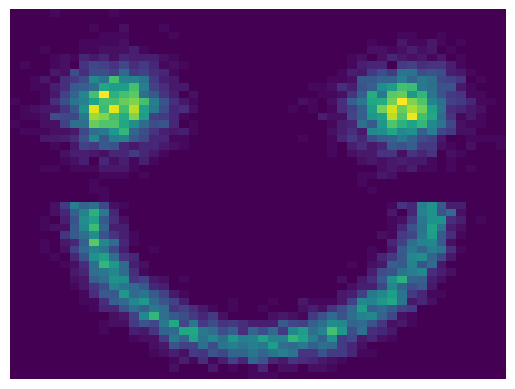

In [34]:
plt.axis("off")
plt.hist2d(data[:,0], data[:,1],bins=50)
plt.show()

In [35]:
class VectorFieldMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128), # Entrada: 2 coordenadas (x,y) + 1 tiempo (t) = 3
            nn.SiLU(), 
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, 2) # Salida: Velocidad (vx, vy)
        )

    def forward(self, x, t):
        # Concatenamos x (batch, 2) y t (batch, 1)
        t_vec = t.view(-1, 1)
        x_input = torch.cat([x, t_vec], dim=-1)
        return self.net(x_input)

In [36]:
# Cargamos el modelo y la configuración del entrenamiento
DEVICE = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 500 # No creo que hiciera falta en realidad
EPOCHS = 2000

In [37]:
# Para recorrer eficientemente el dataset
dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
mse_loss_fn = torch.nn.MSELoss(reduction='mean')

In [41]:
def train_net(model, dataloader, optimizer, epochs=10):
    metrics_dic = {'rec_loss': []}
    for epoch in range(1,epochs+1):
        rec_loss_sum = 0 
        pbar = tqdm(enumerate(dataloader), total=len(dataloader))
        pbar.set_description(f"Epoch {epoch} - Training")
        for batch_idx, batch in pbar:
            # Sampleamos un batch del dataset
            z = batch.to(DEVICE).float()

            # Sampleamos tiempo aleatorio t ~ [0, 1]
            t = torch.rand(BATCH_SIZE, device=DEVICE).view(-1, 1) # vector columna

            # Sampleamos ruido gaussiano
            eps = torch.randn_like(z).to(DEVICE)

            x = t * z + (1-t) * eps

            output = model(x, t)
            
            target = z - eps
            
            rec_loss = mse_loss_fn(output, target)
            optimizer.zero_grad()
            rec_loss.backward()
            optimizer.step()
            rec_loss_sum += rec_loss.item()
            pbar.set_postfix({'rec_loss' : rec_loss_sum / (batch_idx+1)})
        rec_loss_avg = rec_loss_sum / len(dataloader)
        metrics_dic['rec_loss'].append(rec_loss_avg)
    return model, metrics_dic

In [42]:
model = VectorFieldMLP().to(DEVICE)
opt = torch.optim.Adam(model.parameters())
model.train()
model, _ = train_net(model, dataloader, opt, epochs=EPOCHS)

Epoch 2000 - Training: 100%|██████████| 20/20 [00:00<00:00, 754.46it/s, rec_loss=1.35]


In [48]:
@torch.no_grad() # Para que torch no calcule gradientes
def generate_trajectory(model, n=2000, steps=100):
    """
    Generamos datos resolviendo la EDO con el método euler
    """
    model.eval() # Necesario para usar la red 

    noise = torch.randn(n, 2).to(DEVICE)
    x_t = [noise]
    h = 1.0 / steps
    
    for i in range(steps):
        t_val = i / steps # Lleva el contador de en qué momento t estamos (entre 0 y 1)
        t = torch.full((n,), t_val, device=DEVICE)
        
        x = x_t[-1]
        v = model(x, t) # La red es el campo
        x = x + v * h # Euler
        x_t.append(x)
        
    return np.array(x_t)

In [ ]:
x_t = generate_trajectory(model)


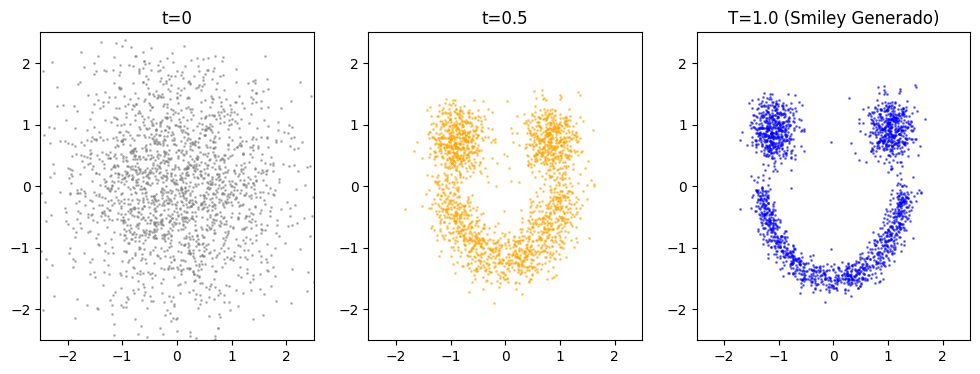

In [ ]:
plt.figure(figsize=(12, 4))

# Estado Inicial (Ruido)
plt.subplot(1, 3, 1)
plt.scatter(x_t[0][:, 0], x_t[0][:, 1], s=1, alpha=0.5, color='gray')
plt.title("t=0")
plt.xlim(-2.5, 2.5); plt.ylim(-2.5, 2.5)

# Estado Intermedio
plt.subplot(1, 3, 2)
mid_step = 50
plt.scatter(x_t[mid_step][:, 0], x_t[mid_step][:, 1], s=1, alpha=0.5, color='orange')
plt.title("t=0.5")
plt.xlim(-2.5, 2.5); plt.ylim(-2.5, 2.5)

# Estado Final (Generado)
plt.subplot(1, 3, 3)
plt.scatter(x_t[-1][:, 0], x_t[-1][:, 1], s=1, alpha=0.5, color='blue')
plt.title("T=1.0 (Smiley Generado)")
plt.xlim(-2.5, 2.5); plt.ylim(-2.5, 2.5)

plt.show()

In [56]:
import pandas as pd
n_steps, n_samples, _ = x_t.shape
steps = np.repeat(np.arange(n_steps), n_samples)
ids = np.tile(np.arange(n_samples), n_steps)
coords = x_t.reshape(-1, 2)

export = pd.DataFrame({
    'step': steps,
    'ids': ids,
    'x': coords[:, 0],
    'y': coords[:, 1]
})

export.to_csv('trayectoria.csv', index = False)